In [48]:
%matplotlib inline

import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.resample import TimeGrouper
from pandas.tseries.offsets import DateOffset
import vincent as v


db = MongoClient('localhost',27017)['twitter_db']

# Make a query to the specific DB and Collection
collection = db['twitter_collection']



# Tweets per Language

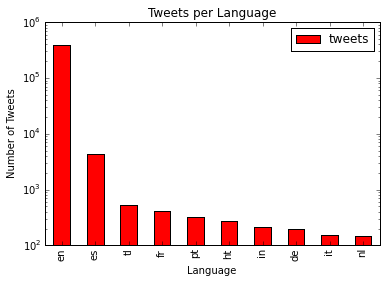

In [3]:
cursor = collection.aggregate(
    [
        {"$group": {"_id": "$lang", "count": {"$sum": 1}}},
        { "$sort": { "count": -1 }}
    ]
)
langFrame = pd.DataFrame(list(cursor))
langFrame.columns = ['lang','tweets']
langFrame = langFrame[langFrame['lang'] != 'und']
langFrame[:10].plot(x='lang',y='tweets',kind='bar',logy=True,color='red')
plt.xlabel('Language')
plt.ylabel('Number of Tweets')
plt.title('Tweets per Language')
plt.savefig('language_graph.png',dpi=180)

# Tweets over Time

In [15]:
#Select 'created_at'
cursor = collection.find({},{"created_at":1})
dateFrame = pd.DataFrame(list(cursor))

#Convert to datetime
dateFrame['created_at'] = pd.to_datetime(dateFrame['created_at'])
dateFrame.set_index('created_at', drop=False, inplace=True)
dateFrame.index = dateFrame.index.tz_localize('GMT').tz_convert('EST')
dateFrame.index = dateFrame.index - DateOffset(hours = 12)
dateFrame1m = dateFrame['created_at'].resample('1t', how='count')

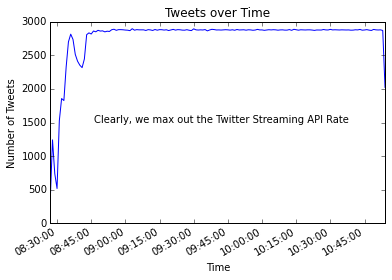

In [77]:
#Visualize
fig, ax = plt.subplots()

plt.title("Tweets over Time")
plt.ylabel("Number of Tweets")
ax = dateFrame1m.plot()
ax.text("2016-02-25 09:42:00-05:00",1500,'Clearly, we max out the Twitter Streaming API Rate',horizontalalignment='center')
plt.xlabel("Time")
plt.savefig('tweets_over_time.png',dpi=180)